# Feature Translation Service - SWORD River Demo

This Jupyter Notebook contains examples related to querying river reaches (segments) using the SWOT River Database (SWORD) Feature Translation Service (FTS), previewing (visualizing) the queried features, and using FTS results to query NASA's Common Metadata Repository (CMR) data.

Example Use Case: In this example, we are using FTS to geospatially search a single river reach, multiple reaches, and river nodes within the database. We then use geospatial coordinates of the features (here river reaches/node along the Kasai River, a tributary of the Congo River in Africa) to query against a dataset in CMR, namely Pre SWOT Hydrology.

**Resources**
- SWOT River Database (SWORD) data can be found here: https://zenodo.org/record/4917236#.YTKLPd9lCST
- Other SWOT SWORD documentation can be found here: https://swot.jpl.nasa.gov/documents/4031/
- MEaSUREs - Pre-Surface Water and Ocean Topography (Pre-SWOT) Hydrology data can be found here: https://podaac.jpl.nasa.gov/MEaSUREs-Pre-SWOT?sections=data

### Required Dependencies

There are three python dependencies that must be available to the python kernel running this notebook. 

- plotly (https://pypi.org/project/plotly/)
- kaleido (https://pypi.org/project/kaleido/)
- geojson (https://pypi.org/project/geojson/)

The next cell installs them when the cell is run.

In [1]:
!pip install plotly geojson kaleido

First, we define a function to query the FTS service for a single reach, multiple reaches, or river nodes. This function returns the properties of river reaches including name, length, coordinates as well as individual node properties.

In [2]:
import requests
import json
import geojson
import pprint
import plotly.graph_objects as go

from IPython.display import JSON, Image

def response_to_FeatureCollection(response):
    """
    This function will return a geojson.FeatureCollection representation of the features found
    in the provided response.
    Parameters
    ----------
    response : requests.Response
        Response object returned from a GET request on the FTS rivers endpoint.
    Returns
    -------
    geojson.FeatureCollection
        FeatureCollection containing all features extracted from the response.
    """
    featureList = []
    for reach_id, reach_json in response.json()['results'].items():
        reach_feature = geojson.loads(json.dumps(reach_json['geojson']))
        reach_feature['properties']={k:v for k,v in reach_json.items() if k not in ['geojson', 'geometry']}
        featureList.append(reach_feature)
    featureCollection = geojson.FeatureCollection(featureList)
    return featureCollection



We define another function to calculate the center coordinates of features. This function returns the center of a single reach or multiple reaches. 

In [3]:
def estimate_center_of_FeatureCollection(featureCollection):
    """
    This function does a very simplistic estimation of the center of all features in the given FeatureCollection.
    Parameters
    ----------
    featureCollection : geojson.FeatureCollection
        Estimate the center lon, lat of this FeatureCollection.
    Returns
    -------
    tuple(float, float)
        Estimated center longitude, center latitude
    """
    lats = [xy[1] for feature in featureCollection['features'] for xy in feature['coordinates']]
    lons = [xy[0] for feature in featureCollection['features'] for xy in feature['coordinates']]

    center_lat = (min(lats) + max(lats)) / 2
    center_lon = (min(lons) + max(lons)) / 2
    
    return center_lon, center_lat

# Plot a Single River Reach

In this section, we query the FTS SWORD service using a single Reach ID (from SWORD). In this example, we use the river Reach ID `13227000061`. This ID represents a specific reach along the Kasai River, a tributary of the Congo River in Africa. 

In [4]:
response = requests.get("https://fts.podaac.earthdata.nasa.gov/rivers/reach/13227000061")
featureCollection = response_to_FeatureCollection(response)

pprint.pprint(response.json(), compact=True, width=60, depth=2)

{'hits': 1,
 'results': {'13227000061': {...}},
 'search on': {'exact': False,
               'page_number': 1,
               'page_size': 100,
               'parameter': 'reach'},
 'status': '200 OK',
 'time': '6.778 ms.'}


Now we can plot this reach and calculate  the center of the reach.

20.9611425 -4.6221515


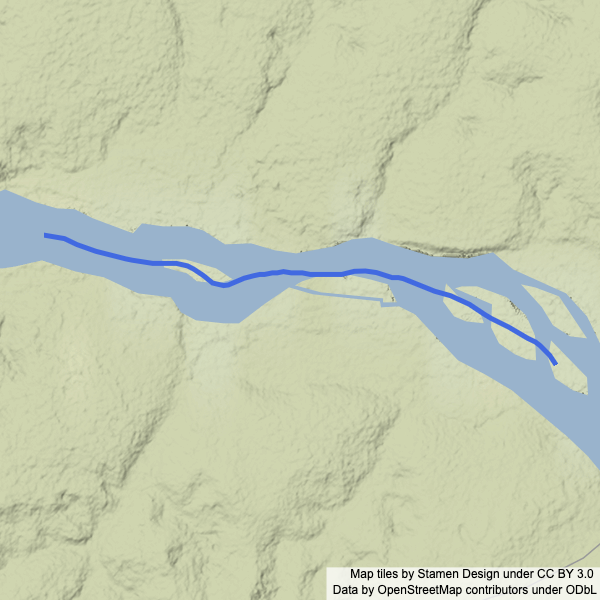

In [5]:
fig = go.Figure(
    go.Scattermapbox(),
    layout = {
        'mapbox': {
            'style': "stamen-terrain",
            'zoom': 12
        },
        'margin': {'l':0, 'r':0, 'b':0, 't':0},
    }
)

fig.update_mapboxes(layers=[
    {
        'source': feature, 
        'type': "line", 
        'line': {'width': 5},
        'below': "traces", 
        'color': "royalblue"
    } for feature in featureCollection.features])

center_lon, center_lat = estimate_center_of_FeatureCollection(featureCollection)

fig.update_layout(
    mapbox = {
        'center': { 'lon':  center_lon, 'lat': center_lat}
    }
)

print(center_lon,center_lat)
Image(fig.to_image(format="png", width=600, height=600))

The below cell plots the river reach using an interactive map. You can zoom out to see where the reach is located.

In [ ]:
fig.show()

# Plot Multiple River Reaches

In this section, we query the FTS SWORD service over multiple river reaches. In this example, we use ID `132270000`. This ID represents multiple reaches along the Kasai River, a tributary of the Congo River in Africa. Note that this reach includes the reach ID of `13227000061` we plotted earlier. The response includes 9 individual reaches.

In [6]:
response = requests.get("https://fts.podaac.earthdata.nasa.gov/rivers/reach/132270000")
featureCollection = response_to_FeatureCollection(response)

pprint.pprint(response.json(), compact=True, width=60, depth=2)

{'hits': 9,
 'results': {'13227000011': {...},
             '13227000021': {...},
             '13227000031': {...},
             '13227000041': {...},
             '13227000051': {...},
             '13227000061': {...},
             '13227000071': {...},
             '13227000081': {...},
             '13227000091': {...}},
 'search on': {'exact': False,
               'page_number': 1,
               'page_size': 100,
               'parameter': 'reach'},
 'status': '200 OK',
 'time': '25.377 ms.'}


Now we can plot these multiple reaches and calculate  the center of the features.

20.7374665 -4.596502


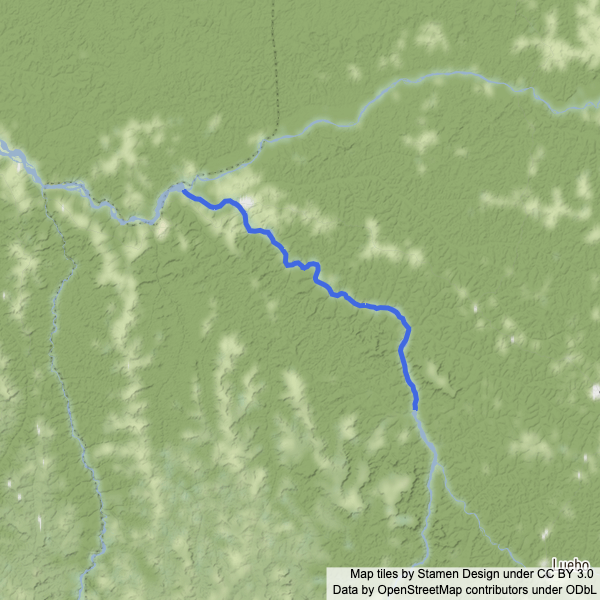

In [7]:
fig = go.Figure(
    go.Scattermapbox(),
    layout = {
        'mapbox': {
            'style': "stamen-terrain",
            'zoom': 8
        },
        'margin': {'l':0, 'r':0, 'b':0, 't':0},
    }
)

fig.update_mapboxes(layers=[
    {
        'source': feature, 
        'type': "line", 
        'line': {'width': 5},
        'below': "traces", 
        'color': "royalblue"
    } for feature in featureCollection.features])

center_lon, center_lat = estimate_center_of_FeatureCollection(featureCollection)

fig.update_layout(
    mapbox = {
        'center': { 'lon':  center_lon, 'lat': center_lat}
    }
)

print(center_lon,center_lat)
Image(fig.to_image(format="png", width=600, height=600))

The below cell plots the river reaches using an interactive map. You can zoom out to see where these reaches are located.

In [ ]:
fig.show()

# Plot River Nodes

In this section, we query the FTS SWORD service for river nodes. In this example, we use the ID of  `13227000060`. Note that this ID corresponds to the same reach ID `13227000061` we used earlier. The only difference is that the last digit of `0` corresponds to all the individual *nodes* along the reach. If the last digit is `1` in the reach ID, it corresponds to the overall properties of the *reach* itself. The response returns 52 nodes along the reach.

In [8]:
response = requests.get("https://fts.podaac.earthdata.nasa.gov/rivers/node/13227000060")

featureCollection = response_to_FeatureCollection(response)

pprint.pprint(response.json(), compact=True, width=60, depth=2)

{'hits': 52,
 'results': {'13227000060011': {...},
             '13227000060021': {...},
             '13227000060031': {...},
             '13227000060041': {...},
             '13227000060051': {...},
             '13227000060061': {...},
             '13227000060071': {...},
             '13227000060081': {...},
             '13227000060091': {...},
             '13227000060101': {...},
             '13227000060111': {...},
             '13227000060121': {...},
             '13227000060131': {...},
             '13227000060141': {...},
             '13227000060151': {...},
             '13227000060161': {...},
             '13227000060171': {...},
             '13227000060181': {...},
             '13227000060191': {...},
             '13227000060201': {...},
             '13227000060211': {...},
             '13227000060221': {...},
             '13227000060231': {...},
             '13227000060241': {...},
             '13227000060251': {...},
             '13227000060261': {...},

Now we can plot the river nodes and calculate the center of the nodes.

20.9613855 -4.6217735


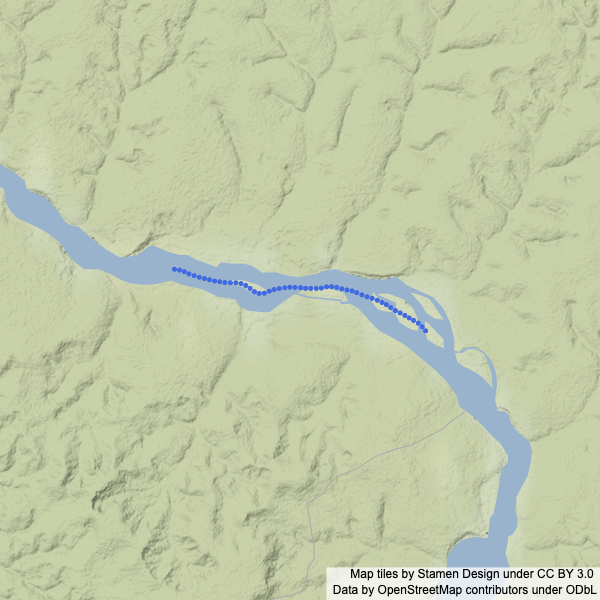

In [9]:

fig = go.Figure(
    go.Scattermapbox(),
    layout = {
        'mapbox': {
            'style': "stamen-terrain",
            'zoom': 11
        },
        'margin': {'l':0, 'r':0, 'b':0, 't':0},
    }
)

fig.update_mapboxes(layers=[
    {
        'source': feature, 
        'type': "circle", 
        'circle': {'radius': 3},
        'below': "traces", 
        'color': "royalblue"
    } for feature in featureCollection.features])


lats = [feature['coordinates'][1] for feature in featureCollection['features']]
lons = [feature['coordinates'][0] for feature in featureCollection['features']]

center_lat = (min(lats) + max(lats)) / 2
center_lon = (min(lons) + max(lons)) / 2

fig.update_layout(
    mapbox = {
        'center': { 'lon':  center_lon, 'lat': center_lat}
    }
)

print(center_lon,center_lat)
Image(fig.to_image(format="png", width=600, height=600))

In [ ]:
fig.show()

## Query CMR by Coordinates

Here is a another useful example of the Feature Translation Service. We can use results obtained from the FTS to then directly and automatically query data using CMR. We will use the coordinate information of a single reach to search for granules available through the [Pre SWOT Hydrology GRRATS Daily River Heights](https://podaac.jpl.nasa.gov/dataset/PRESWOT_HYDRO_GRRATS_L2_DAILY_VIRTUAL_STATION_HEIGHTS_V2) and Storage Version 2 data. 

We query CMR using the previously used reach ID of `13227000061` over Kasai River, a tributary of the Congo River in Africa.

In [10]:
response = requests.get("https://fts.podaac.earthdata.nasa.gov/rivers/reach/13227000061")
featureCollection = response_to_FeatureCollection(response)

pprint.pprint(response.json(), compact=True, width=60, depth=2)

{'hits': 1,
 'results': {'13227000061': {...}},
 'search on': {'exact': False,
               'page_number': 1,
               'page_size': 100,
               'parameter': 'reach'},
 'status': '200 OK',
 'time': '4.289 ms.'}


The next cell queries CMR using the coordinates of the reach. Note that coordinates should be listed in the format lon1, lat1, lon2, lat2, lon3, lat3, and so on. The CMR json response proivides a link to the data file (granule) from the Pre SWOT Hydroology GRRATS Daily River Heights data collection that overlaps the geospatial search from FTS-SWORD for the river reaches of interest, e.g. `"href": "https://podaac-tools.jpl.nasa.gov/drive/files/allData/preswot_hydrology/L2/rivers/daily//Africa_Congo1kmdaily.nc"`

In [11]:
COLLECTION_ID = "C1674168562-PODAAC" #  Pre SWOT Hydrology GRRATS Daily River Heights and Storage Version 2

# this function returns the unique set of lon,lat coordinates. When quering CMR, we need to delete repeated points with the same lon,lat
def get_unique_numbers(numbers):
    unique = []

    for number in numbers:
        if number in unique:
            continue
        else:
            unique.append(number)
    return unique

# derive lon,lat of nodes along the reach
latlon = [xy[:] for feature in featureCollection['features'] for xy in feature['coordinates']]

# delete the repeated nodes if available
unique_lonlat=get_unique_numbers(latlon)

# create one single list of lon,lat coordinates 
flat_list = []
for sublist in unique_lonlat:
    for item in sublist:
        flat_list.append(item)

#extra steps to create a string of the list
flat_list_string = str(flat_list)[1:-1]
lonlat_nodes = flat_list_string.replace(" ", "")


#query CMR
cmr_response = requests.get("https://cmr.earthdata.nasa.gov/search/granules.json?line={}&echo_collection_id={}&pretty=True".format(lonlat_nodes, COLLECTION_ID))


# Make it look nice
print(json.dumps(cmr_response.json(), indent = 4))

{
    "feed": {
        "updated": "2021-09-09T22:02:30.060Z",
        "id": "https://cmr.earthdata.nasa.gov:443/search/granules.json?line=20.917191,-4.611049,20.917461,-4.611103,20.917731,-4.611157,20.918002,-4.611212,20.918272,-4.611266,20.918543,-4.611266,20.918813,-4.61132,20.919084,-4.611375,20.919354,-4.611429,20.919625,-4.611483,20.919895,-4.611538,20.920166,-4.611538,20.920436,-4.611592,20.920707,-4.611646,20.920977,-4.611755,20.921248,-4.611863,20.921518,-4.612026,20.921788,-4.612135,20.922059,-4.612298,20.922329,-4.612406,20.9226,-4.612569,20.92287,-4.612678,20.923141,-4.612786,20.923411,-4.612895,20.923682,-4.613004,20.923952,-4.613058,20.924223,-4.613166,20.924493,-4.613275,20.924763,-4.613329,20.925034,-4.613438,20.925304,-4.613547,20.925575,-4.613601,20.925845,-4.613709,20.926116,-4.613818,20.926386,-4.613872,20.926657,-4.613927,20.926927,-4.614035,20.927198,-4.61409,20.927468,-4.614144,20.927739,-4.614198,20.928009,-4.614307,20.92828,-4.614361,20.92855,-4.614415,20.92882